## **ECS708P Machine Learning Mini Project**

**Name : Abhinav Gyani**

**Student ID : 200566799**


# **Summary**

The mini-project consists of two components:
1. **Basic solution** [6 marks]: Using the MLEnd dataset, build a model that predicts the intonation of a short audio segment.
2. **Advanced solution** [10 marks]: There are two options. (i) Formulate a machine learning problem that can be attempted using the MLEnd dataset and build a solution model (e.g. identify a numeral in a short sequence). (ii) Create a product that uses the functionality provided by a model trained on the MLEnd dataset (e.g. identify a number based on the identification of individual numerals).

# 1. **Basic solution**

The aim of this task is to create a classification model to predict the intonation of a short audio segment. We create two feature sets as described in sebsequent sections and build four classification models to evaluate and compare.

## **1.1. Environment setup**
Below code blocks import all the necessary modules required and also reads the audio files and the training set provided.

In [26]:
from google.colab import drive

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os, sys, re, pickle, glob
import urllib.request
import zipfile

#from IPython.display import Audio
import IPython.display as ipd
from tqdm import tqdm
import librosa
import librosa.display
import soundfile


In [27]:
drive.mount('/content/drive')
files = glob.glob('/content/drive/MyDrive/Data/MLEnd/training/*/*.wav')
labels = pd.read_csv('/content/drive/MyDrive/Data/MLEnd/trainingMLEnd.csv')

Mounted at /content/drive


## **1.2. Feature engineering, extraction and pre-processing**

We create two feature sets : Feature set A (primary) and Feature set B. Both can be fed to the models one by one to perform the classification task.

### **Feature set A preparation and pre-processing**
We create a dataset with below features and label using the 20,000 audio samples from MileEnd dataset.
+ Audio sample filename
+ Features (Power, Pitch mean, Pitch Standard deviation, Fraction of voiced region)
+ Numeric ([0-9], [10-20], 30, 40, 50, 60, 70, 80, 90, 100, 1000, 1000000, 1000000000)
+ Label (Intonation)

In [28]:
def getPitch(x,fs,winLen=0.02):
  #winLen = 0.02 
  p = winLen*fs
  frame_length = int(2**int(p-1).bit_length())
  hop_length = frame_length//2

  #f0 - (np.ndarray) time series of fundamental frequencies (in hertz)
  #voiced_flag - (np.ndarray) time series containing boolean flags indicating whether a frame is voiced or not.
  #voiced_probs - (np.ndarray) time series containing the probability that a frame is voiced.
  
  f0, voiced_flag, voiced_probs = librosa.pyin(y=x, fmin=80, fmax=450, sr=fs,frame_length=frame_length,hop_length=hop_length)
  return f0,voiced_flag

In [29]:
def getXy(files,labels_file,scale_audio=False, onlySingleDigit=False):
  X,y =[],[]                        #features and labels arrays
  for file in tqdm(files):          #process all 20K files.
    fileID = file.split('/')[-1]    #extract .wav filename from full file path.
    yi = list(labels_file[labels_file['File ID']==fileID]['digit_label'])[0]
    if onlySingleDigit and yi>9:    #onlySingleDigit=False in this case so that all numbers are processed.
      continue
    else:
      fs = None                     #if None, fs would be 22050
      x, fs = librosa.load(file,sr=fs)
      if scale_audio:
        x = x/np.max(np.abs(x))     #get maximum absolute value from the audio time series ndarray.
      
      f0, voiced_flag = getPitch(x,fs,winLen=0.02)
      
      power = np.sum(x**2)/len(x)
      pitch_mean = np.nanmean(f0) if np.mean(np.isnan(f0))<1 else 0
      pitch_std  = np.nanstd(f0) if np.mean(np.isnan(f0))<1 else 0
      voiced_fr = np.mean(voiced_flag)

      xi = [power,pitch_mean,pitch_std,voiced_fr]
      X.append(xi)
      y.append(yi)

  return np.array(X),np.array(y)

In [ ]:
# Read all the 20,000 audio sample files for all numbers.
X,y = getXy(files,labels_file=labels,scale_audio=True, onlySingleDigit=False)

In [ ]:
# X = features (power, pitch mean, pitch standard deviation, fraction of voiced region)
# y = pattern (number recorded in audio sample)
df_X = pd.DataFrame(data=X, columns=["Power","Pitch mean","Pitch SD","Fraction of voiced region"])
df_y = pd.DataFrame(data=y, columns=["Pattern"])
df_final = pd.concat([df_X,df_y], axis=1)

fileIds = []
intonation = []
for file in tqdm(files):
  filename = file.split('/')[-1]    #extract .wav filename from full file path.
  fileIds.append(filename)
  mood = list(labels[labels['File ID']==filename]['intonation'])[0]
  intonation.append(mood)

df_filenames = pd.DataFrame(data=fileIds, columns=["Filename"])
df_intonation = pd.DataFrame(data=intonation, columns=["Intonation"])
df_full = pd.concat([df_filenames,df_final,df_intonation],axis=1)

#Save feature set A to a CSV file. This file is used in subsequent runs.
df_full.to_csv('/content/drive/MyDrive/Data/basic_features_set_A.csv',index=False)
display(df_full)


In [30]:
#We now load the data from our prepared features dataset for EDA.

df_data = pd.read_csv('basic_features_set_A.csv')
display(df_data)
print(df_data.describe())

,Filename,Power,Pitch mean,Pitch SD,Fraction of voiced region,Pattern,Intonation
0,0018596.wav,0.038618,187.723934,62.598813,0.291139,1,question
1,0008785.wav,0.042435,128.812251,20.912529,0.313953,40,excited
2,0019850.wav,0.006295,130.283099,5.193614,0.241176,9,excited
3,0001979.wav,0.017070,171.916609,26.854425,0.111888,6,question
4,0010874.wav,0.022278,196.902587,37.141417,0.290123,80,excited
...,...,...,...,...,...,...,...
19995,0009482.wav,0.020046,372.357546,54.894876,0.347826,8,excited
19996,0008944.wav,0.021891,163.897702,5.387707,0.312139,15,bored
19997,0019691.wav,0.008093,125.462308,9.071763,0.201087,18,neutral
19998,0012276.wav,0.012445,104.883912,5.581004,0.179856,16,bored


              Power    Pitch mean  ...  Fraction of voiced region       Pattern
count  20000.000000  20000.000000  ...               20000.000000  2.000000e+04
mean       0.021682    180.380151  ...                   0.343054  3.093120e+07
std        0.014054     75.981041  ...                   0.163653  1.730456e+08
min        0.000712      0.000000  ...                   0.000000  0.000000e+00
25%        0.012086    120.767343  ...                   0.232759  7.000000e+00
50%        0.018708    171.426095  ...                   0.333333  1.500000e+01
75%        0.027739    226.307401  ...                   0.442308  5.000000e+01
max        0.260630    449.941853  ...                   0.990991  1.000000e+09

[8 rows x 5 columns]


Below table represents the mean value for all four features per intonation wise (generated via Excel). Interestingly, the pitch mean and deviation for "bored" is the lowest (as it should be).

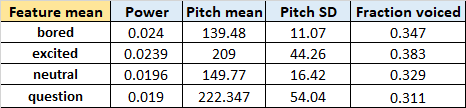

It is crucial to scale the features before fitting them to the models. Without scaling, some features might be given extra weightage from the model. If there is a difference in the variance of features simply because of their possible range of values, then a model will learn that the features with the greatest variance are the most important.

In [31]:
#Pre-processing like standardization, normalization done here

features_A_unscaled = df_data[['Power','Pitch mean','Pitch SD','Fraction of voiced region']]
labels = df_data['Intonation'].to_numpy()

print("\n ----------- Statistical Analysis of unscaled feature set A -------------")
#Feature 1: Power
feature_power = features_A_unscaled["Power"]
power_min = feature_power.min()
power_max = feature_power.max()
power_mean = feature_power.mean()
power_std = feature_power.std()
print(f'\n Power (overall):                       \
min = {power_min:.4f}, \
max = {power_max:.4f}, \
mean = {power_mean:.4f}, \
std = {power_std:.4f}')

#Feature 2: Pitch mean
feature_pitch_mean = features_A_unscaled["Pitch mean"]
pitchMean_min = feature_pitch_mean.min()
pitchMean_max = feature_pitch_mean.max()
pitchMean_mean = feature_pitch_mean.mean()
pitchMean_std = feature_pitch_mean.std()
print(f'\n Pitch Mean (overall):                  \
min = {pitchMean_min:.4f}, \
max = {pitchMean_max:.4f}, \
mean = {pitchMean_mean:.4f}, \
std = {pitchMean_std:.4f}')

#Feature 3: Pitch SD
feature_pitchSD = features_A_unscaled["Pitch SD"]
pitchSD_min = feature_pitchSD.min()
pitchSD_max = feature_pitchSD.max()
pitchSD_mean = feature_pitchSD.mean()
pitchSD_std = feature_pitchSD.std()
print(f'\n Pitch SD (overall):                    \
min = {pitchSD_min:.4f}, \
max = {pitchSD_max:.4f}, \
mean = {pitchSD_mean:.4f}, \
std = {pitchSD_std:.4f}')

#Feature 1: Fraction of voiced region
feature_voice = features_A_unscaled["Fraction of voiced region"]
voice_min = feature_voice.min()
voice_max = feature_voice.max()
voice_mean = feature_voice.mean()
voice_std = feature_voice.std()
print(f'\n Fraction of voiced region (overall):   \
min = {voice_min:.4f}, \
max = {voice_max:.4f}, \
mean = {voice_mean:.4f}, \
std = {voice_std:.4f}')

print("\n ----------------- Standard scaling of feature set A --------------")

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
features_A_stdscaled = scaler.fit_transform(features_A_unscaled)

features_A_scaled_df = pd.DataFrame(features_A_stdscaled, columns=["Power_scaled", "Pitch_mean_scaled", "PitchSD_scaled","Fraction_voice_scaled"])
display(features_A_scaled_df)



 ----------- Statistical Analysis of unscaled feature set A -------------

 Power (overall):                       min = 0.0007, max = 0.2606, mean = 0.0217, std = 0.0141

 Pitch Mean (overall):                  min = 0.0000, max = 449.9419, mean = 180.3802, std = 75.9810

 Pitch SD (overall):                    min = 0.0000, max = 165.3016, mean = 31.4529, std = 29.1323

 Fraction of voiced region (overall):   min = 0.0000, max = 0.9910, mean = 0.3431, std = 0.1637

 ----------------- Standard scaling of feature set A --------------


,Power_scaled,Pitch_mean_scaled,PitchSD_scaled,Fraction_voice_scaled
0,1.205172,0.096655,1.069146,-0.317232
1,1.476783,-0.678711,-0.361820,-0.177822
2,-1.094856,-0.659353,-0.901403,-0.622536
3,-0.328141,-0.111393,-0.157852,-1.412570
4,0.042420,0.217460,0.195270,-0.323439
...,...,...,...,...
19995,-0.116415,2.526712,0.804693,0.029161
19996,0.014856,-0.216934,-0.894740,-0.188911
19997,-0.966972,-0.722802,-0.768278,-0.867508
19998,-0.657289,-0.993644,-0.888105,-0.997242


### **Feature set B preparation and pre-processing**

We can extract more features out of the given audio samples. *librosa* has methods to analyse audio signals and extract features from them. We create functions to get a chromagram, a mel spectorgram, and MFC coefficients for each audio sample. Because the chromagram, mel spectrogram and MFCCs are calculated on audio frames produced by STFT, we're going to get a matrix back from each function, so we'll take the mean of those matrices to produce a single feature array for each feature and each audio sample, i.e. 3 feature arrays per audio sample.

*Chromagram*: Will produce 12 features, one for each of 12 pitch classes.

*Mel Spectrogram*: Will produce 128 features (number of mel frequency bands n_mels=128)

*MFCC*: Will produce 40 MFCCs (number of coefficients n_mfcc=40)


In [32]:
def feature_chromagram(waveform, sample_rate):
    stft_spectrogram=np.abs(librosa.stft(waveform)) #calculation of STFT
    # Produce the chromagram for all STFT frames and get the mean of each column of the resulting matrix to create a feature array
    chromagram=np.mean(librosa.feature.chroma_stft(S=stft_spectrogram, sr=sample_rate).T,axis=0)
    return chromagram

def feature_melspectrogram(waveform, sample_rate):
    # Produce the mel spectrogram for all STFT frames and get the mean of each column of the resulting matrix to create a feature array
    # Using 8khz as upper frequency bound should be enough for most speech classification tasks
    melspectrogram=np.mean(librosa.feature.melspectrogram(y=waveform, sr=sample_rate, n_mels=128, fmax=8000).T,axis=0)
    return melspectrogram

def feature_mfcc(waveform, sample_rate):
    # Compute the MFCCs for all STFT frames and get the mean of each column of the resulting matrix to create a feature array
    # 40 filterbanks = 40 coefficients
    mfc_coefficients=np.mean(librosa.feature.mfcc(y=waveform, sr=sample_rate, n_mfcc=40).T, axis=0) 
    return mfc_coefficients

def get_features(file):
    # load an individual soundfile
     with soundfile.SoundFile(file) as audio:
        waveform = audio.read(dtype="float32")
        sample_rate = audio.samplerate
        # compute feature set B of soundfile
        chromagram = feature_chromagram(waveform, sample_rate)
        melspectrogram = feature_melspectrogram(waveform, sample_rate)
        mfc_coefficients = feature_mfcc(waveform, sample_rate)

        feature_matrix=np.array([])
        feature_matrix = np.hstack((chromagram, melspectrogram, mfc_coefficients))
        return feature_matrix

def load_data():
  X,y=[],[]
  count = 0
  for file in tqdm(files):
    fileID = file.split('/')[-1]    #extract .wav filename from full file path.
    yi = list(labels[labels['File ID']==fileID]['intonation'])[0]
    features_B = get_features(file)
    X.append(features_B)
    y.append(yi)
    count += 1
  return np.array(X), np.array(y)


In [ ]:
X,y = load_data()   #Prepare feature set B data.

In [ ]:
#Save feature set B into a CSV file for subsequent runs.
df_X = pd.DataFrame(data=X)
df_y = pd.DataFrame(data=y)
df_features_B_file = pd.concat([df_X,df_y], axis=1)
df_features_B_file.to_csv('/content/drive/MyDrive/Data/basic_features_set_B.csv',index=False)
display(df_features_B_file)

In [33]:
#Reading from file for subsequent runs.
df_features_B_file = pd.read_csv('basic_features_set_B.csv')

#get features
df_features_B = df_features_B_file.iloc[:, :180]
print(df_features_B.shape)

#get labels
df_labels_B = df_features_B_file.iloc[:,-1]
print(df_labels_B.shape)


(20000, 180)
(20000,)


In [34]:
def print_features(df):
    # Check chromagram feature values
    features_df_chromagram = df.loc[:,:11]
    chroma_min = features_df_chromagram.min().min()
    chroma_max = features_df_chromagram.max().max()
    # stack all features into a single series so we don't get a mean of means or stdev of stdevs
    chroma_mean = features_df_chromagram.stack().mean()
    chroma_stdev = features_df_chromagram.stack().std()
    print(f'Chromagram features:        \
    min = {chroma_min:.3f}, \
    max = {chroma_max:.3f}, \
    mean = {chroma_mean:.3f}, \
    deviation = {chroma_stdev:.3f}') 

    # Check mel spectrogram feature values
    features_df_melspectrogram = df.loc[:,12:139]
    mel_min = features_df_melspectrogram.min().min()
    mel_max = features_df_melspectrogram.max().max()
    # stack all features into a single series so we don't get a mean of means or stdev of stdevs
    mel_mean = features_df_melspectrogram.stack().mean()
    mel_stdev = features_df_melspectrogram.stack().std()
    print(f'\nMel Spectrogram features:   \
    min = {mel_min:.3f}, \
    max = {mel_max:.3f}, \
    mean = {mel_mean:.3f}, \
    deviation = {mel_stdev:.3f}')

    # Check MFCC feature values
    features_df_mfcc = df.loc[:,140:179]
    mfcc_min = features_df_mfcc.min().min()
    mfcc_max = features_df_mfcc.max().max()
    # stack all features into a single series so we don't get a mean of means or stdev of stdevs
    mfcc_mean = features_df_mfcc.stack().mean()
    mfcc_stdev = features_df_mfcc.stack().std()
    print(f'\nMFCC features:              \
    min = {mfcc_min:.3f},\
    max = {mfcc_max:.3f},\
    mean = {mfcc_mean:.3f},\
    deviation = {mfcc_stdev:.3f}')


In [ ]:
print_features(df_features_B)

In [35]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

#features_B_unscaled = X
features_B_unscaled = df_features_B

scaler = StandardScaler() 
features_B_stdscaled = scaler.fit_transform(features_B_unscaled)

scaler = MinMaxScaler()
features_B_minmax = scaler.fit_transform(features_B_unscaled)

print('Standard Scaling:\n')
features_B_stdscaled_df = pd.DataFrame(features_B_stdscaled)
print_features(features_B_stdscaled_df)

print('MinMax Scaling:\n')
features_B_minmax_df = pd.DataFrame(features_B_minmax)
print_features(features_B_minmax_df)

Standard Scaling:

Chromagram features:            min = -4.441,     max = 3.145,     mean = 0.000,     deviation = 1.000

Mel Spectrogram features:       min = -0.319,     max = 122.878,     mean = -0.000,     deviation = 1.000

MFCC features:                  min = -5.869,    max = 10.620,    mean = 0.000,    deviation = 1.000
MinMax Scaling:

Chromagram features:            min = 0.000,     max = 1.000,     mean = 0.588,     deviation = 0.146

Mel Spectrogram features:       min = 0.000,     max = 1.000,     mean = 0.003,     deviation = 0.020

MFCC features:                  min = 0.000,    max = 1.000,    mean = 0.451,    deviation = 0.145


## **1.3. Creation of training and validation sets**

We use `train_test_split()` of `scikit-learn` to split our dataset into training and validation sets.

In [36]:
from sklearn.model_selection import train_test_split

#Choose which feature/label set to use for classification model training.
#Comment the ones not to be used.

print('Using feature set A : 4 features, 20k samples')

#print('Using unscaled features...')
#features_train, features_val, label_train, label_val = train_test_split(features_A_unscaled,labels,test_size=0.3,random_state=69)   #unscaled features

print('Using standard scaled features...')
features_train, features_val, label_train, label_val = train_test_split(features_A_stdscaled,labels,test_size=0.3,random_state=69) #standard scaled features

#print('Using feature set B : 180 features, 20k samples')

#print('Using unscaled features...')
#features_train, features_val, label_train, label_val = train_test_split(features_B_unscaled,df_labels_B,test_size=0.3,random_state=69)   #unscaled features

#print('Using standard scaled features...')
#features_train, features_val, label_train, label_val = train_test_split(features_B_stdscaled,df_labels_B,test_size=0.3,random_state=69)  #standard scaler features

#print('Using minmax scaled features...')
#features_train, features_val, label_train, label_val = train_test_split(features_B_minmax,df_labels_B,test_size=0.3,random_state=69)     #minmax scaler features


print('Features (training)   shape = ', features_train.shape)
print('Labels   (training)   shape = ', label_train.shape)
print('Features (validation) shape = ', features_val.shape)
print('Labels   (validation) shape = ', label_val.shape)

print(label_train)

Using feature set A : 4 features, 20k samples
Using standard scaled features...
Features (training)   shape =  (14000, 4)
Labels   (training)   shape =  (14000,)
Features (validation) shape =  (6000, 4)
Labels   (validation) shape =  (6000,)
['question' 'bored' 'neutral' ... 'neutral' 'question' 'excited']


## **1.4. Machine learning classification models**

Model 1 : Support Vector Machine

In [151]:
from sklearn import svm


svm_model  = svm.SVC(C=1,gamma=2)
svm_model.fit(features_train,label_train)

label_train_pred = svm_model.predict(features_train)
label_val_pred = svm_model.predict(features_val)

print('Training Accuracy', np.mean(label_train_pred==label_train))
print('Validation  Accuracy', np.mean(label_val_pred==label_val))

Training Accuracy 0.5972857142857143
Validation  Accuracy 0.5485


Model 2 : K-nearest neighbours

In [152]:
from sklearn.neighbors import KNeighborsClassifier

####### Default kNN  ########
knn_model = KNeighborsClassifier()
knn_model.fit(features_train, label_train)
print(f'Default kNN Model\'s accuracy on training set is {100*knn_model.score(features_train, label_train):.2f}%')
print(f'Default kNN Model\'s accuracy on test set is {100*knn_model.score(features_val, label_val):.2f}%\n')

##### tuned kNN ######
knn_model = KNeighborsClassifier(n_neighbors = 5,weights = 'distance',algorithm = 'brute',leaf_size = '30',n_jobs=4)
knn_model.fit(features_train, label_train)

print(f'kNN Model\'s accuracy on training set is {100*knn_model.score(features_train, label_train):.2f}%')
print(f'kNN Model\'s accuracy on test set is {100*knn_model.score(features_val, label_val):.2f}%')


Default kNN Model's accuracy on training set is 66.01%
Default kNN Model's accuracy on test set is 49.53%

kNN Model's accuracy on training set is 100.00%
kNN Model's accuracy on test set is 50.45%


Model 3 : Random Forest Classifier

In [153]:
from sklearn.ensemble import RandomForestClassifier

####### Default Random Forest ########
rfc_model = RandomForestClassifier(random_state=69)
rfc_model.fit(features_train, label_train)

print(f'Default Random Forest Model\'s accuracy on training set is {100*rfc_model.score(features_train, label_train):.2f}%')
print(f'Default Random Forest Model\'s accuracy on test set is {100*rfc_model.score(features_val, label_val):.2f}%\n')


########## Tuned Random Forest #######
rfc_model = RandomForestClassifier(
    n_estimators = 500, 
    criterion ='entropy',
    warm_start = True,
    max_features = 'sqrt',
    oob_score = 'True', # more on this below
    random_state=69  
) 

rfc_model.fit(features_train, label_train)

print(f'Random Forest Model\'s accuracy on training set is {100*rfc_model.score(features_train, label_train):.2f}%')
print(f'Random Forest Model\'s accuracy on test set is {100*rfc_model.score(features_val, label_val):.2f}%')

Default Random Forest Model's accuracy on training set is 100.00%
Default Random Forest Model's accuracy on test set is 53.70%

Random Forest Model's accuracy on training set is 100.00%
Random Forest Model's accuracy on test set is 53.48%


Model 4 : MLP Classifier

In [154]:
from sklearn.neural_network import MLPClassifier

# Default 'off-the-shelf' MLP from sklearn
mlp_model = MLPClassifier(random_state = 69)
mlp_model.fit(features_train, label_train)

print(f'Possible intonations predicted by MLP classification model:{mlp_model.classes_}')
print(f'Unscaled MLP Model\'s accuracy on training set is {100*mlp_model.score(features_train, label_train):.2f}%')
print(f'Unscaled MLP Model\'s accuracy on test set is {100*mlp_model.score(features_val, label_val):.2f}%')

Possible intonations predicted by MLP classification model:['bored' 'excited' 'neutral' 'question']
Unscaled MLP Model's accuracy on training set is 56.31%
Unscaled MLP Model's accuracy on test set is 54.13%


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


## **1.5. Performance Measures**

Different perfromance metrics can be used to evaluate the classification models. Few of them are
+ Accuracy
+ Confusion matrix
+ Precision, Recall, F-score

### **Accuracy**

Classification accuracy (or just accuracy) is the ratio of number of correct predictions to the total number of predictions (or input samples). It is considered to be a good evaluation metric if the classes are balanced, that is, equal number of samples from each class. In the given MileEnd dataset (consisting of 20,000 audio samples), it is known that we have 5000 samples from each intonation class - neutral, boring, excited and question.

Below tables summarizes training and validation accuracies achieved using the above classification models.

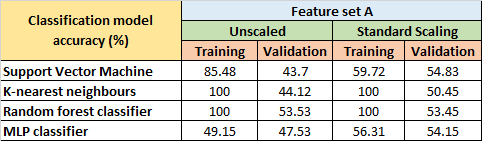

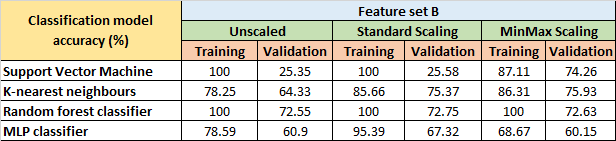

### **Confusion matrix**

Confusion matrix describes the performance of the model on our validation dataset. The vertical axes represent the predicted classes whereas the horizontal axes represent the ground truth classes.

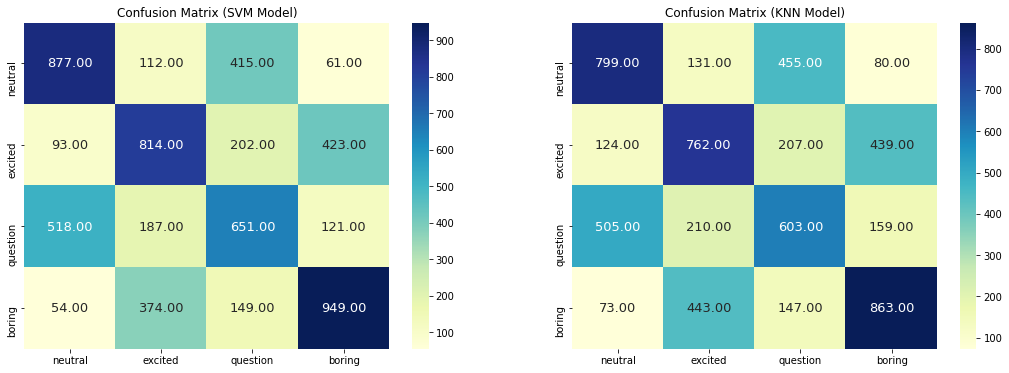

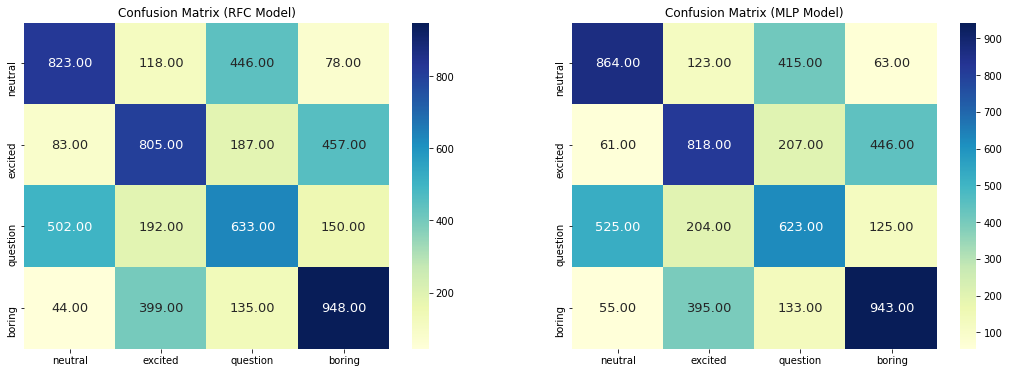

In [155]:
from sklearn.metrics import confusion_matrix
import seaborn as sn

# get predictions on validation set 
svm_label_prediction = svm_model.predict(features_val)
knn_label_prediction = knn_model.predict(features_val)
rfc_label_prediction = rfc_model.predict(features_val)
mlp_label_prediction = mlp_model.predict(features_val)

# build confusion matrix
svm_conf_matrix = confusion_matrix(label_val, svm_label_prediction)
knn_conf_matrix = confusion_matrix(label_val, knn_label_prediction)
rfc_conf_matrix = confusion_matrix(label_val, rfc_label_prediction)
mlp_conf_matrix = confusion_matrix(label_val, mlp_label_prediction)


# set labels for matrix axes from intonations
intonation_list =['neutral','excited','question','boring']
intonation_name = [intonation for intonation in intonation_list]

# make a confusion matrix with labels using a DataFrame
svm_confmatrix_df = pd.DataFrame(svm_conf_matrix, index=intonation_name, columns=intonation_name)
knn_confmatrix_df = pd.DataFrame(knn_conf_matrix, index=intonation_name, columns=intonation_name)
rfc_confmatrix_df = pd.DataFrame(rfc_conf_matrix, index=intonation_name, columns=intonation_name)
mlp_confmatrix_df = pd.DataFrame(mlp_conf_matrix, index=intonation_name, columns=intonation_name)

#display(svm_confmatrix_df)
#display(knn_confmatrix_df)
#display(rfc_confmatrix_df)
#display(mlp_confmatrix_df)

# plot confusion matrices

plt.figure(figsize=(18,6))
plt.subplot(1,2,1)
plt.title('Confusion Matrix (SVM Model)')
sn.heatmap(svm_confmatrix_df, annot=True, annot_kws={"size": 13}, fmt=".2f", cmap="YlGnBu")

plt.subplot(1,2,2)
plt.title('Confusion Matrix (KNN Model)')
sn.heatmap(knn_confmatrix_df, annot=True, annot_kws={"size": 13}, fmt=".2f", cmap="YlGnBu")
plt.show()

plt.figure(figsize=(18,6))
plt.subplot(1,2,1)
plt.title('Confusion Matrix (RFC Model)')
sn.heatmap(rfc_confmatrix_df, annot=True, annot_kws={"size": 13}, fmt=".2f", cmap="YlGnBu")

plt.subplot(1,2,2)
plt.title('Confusion Matrix (MLP Model)')
sn.heatmap(mlp_confmatrix_df, annot=True, annot_kws={"size": 13}, fmt=".2f", cmap="YlGnBu")
plt.show()

### **Precision, Recall, F-score**

*Precision* is the ratio of correctly predicted positive observations to the total predicted positive observations.

*Recall* (Sensitivity) is the ratio of correctly predicted positive observations to all observations in actual class.

*F1 score* is the weighted average of Precision and Recall. Therefore, this score takes both false positives and false negatives into account.

In [157]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

svm_label_pred = svm_model.predict(features_val)
knn_label_pred = knn_model.predict(features_val)
rfc_label_pred = rfc_model.predict(features_val)
mlp_label_pred = mlp_model.predict(features_val)

print('\n ----------- SVM metric ------------')
print(f'Validation Set Accuracy score =  {100*accuracy_score(label_val, svm_label_pred):.3f}%')
print(f'Validation Set Precision score =  {100*precision_score(label_val, svm_label_pred, average="macro"):.3f}%')
print(f'Validation Set Recall score =  {100*recall_score(label_val, svm_label_pred, average="macro"):.3f}%')
print(f'Validation Set F-score score =  {100*f1_score(label_val, svm_label_pred, average="macro"):.3}%')

print('\n ----------- KNN metric ------------')
print(f'Validation Set Accuracy score =  {100*accuracy_score(label_val, knn_label_pred):.3f}%')
print(f'Validation Set Precision score =  {100*precision_score(label_val, knn_label_pred, average="macro"):.3f}%')
print(f'Validation Set Recall score =  {100*recall_score(label_val, knn_label_pred, average="macro"):.3f}%')
print(f'Validation Set F-score score =  {100*f1_score(label_val, knn_label_pred, average="macro"):.3}%')

print('\n ----------- RFC metric ------------')
print(f'Validation Set Accuracy score =  {100*accuracy_score(label_val, rfc_label_pred):.3f}%')
print(f'Validation Set Precision score =  {100*precision_score(label_val, rfc_label_pred, average="macro"):.3f}%')
print(f'Validation Set Recall score =  {100*recall_score(label_val, rfc_label_pred, average="macro"):.3f}%')
print(f'Validation Set F-score score =  {100*f1_score(label_val, rfc_label_pred, average="macro"):.3}%')

print('\n ----------- MLP metric ------------')
print(f'Validation Set Accuracy score =  {100*accuracy_score(label_val, mlp_label_pred):.3f}%')
print(f'TeValidationst Set Precision score =  {100*precision_score(label_val, mlp_label_pred, average="macro"):.3f}%')
print(f'Validation Set Recall score =  {100*recall_score(label_val, mlp_label_pred, average="macro"):.3f}%')
print(f'Validation Set F-score score =  {100*f1_score(label_val, mlp_label_pred, average="macro"):.3}%')


 ----------- SVM metric ------------
Validation Set Accuracy score =  54.850%
Validation Set Precision score =  54.656%
Validation Set Recall score =  54.815%
Validation Set F-score score =  54.7%

 ----------- KNN metric ------------
Validation Set Accuracy score =  50.450%
Validation Set Precision score =  50.307%
Validation Set Recall score =  50.414%
Validation Set F-score score =  50.4%

 ----------- RFC metric ------------
Validation Set Accuracy score =  53.483%
Validation Set Precision score =  53.271%
Validation Set Recall score =  53.426%
Validation Set F-score score =  53.3%

 ----------- MLP metric ------------
Validation Set Accuracy score =  54.133%
TeValidationst Set Precision score =  53.883%
Validation Set Recall score =  54.087%
Validation Set F-score score =  54.0%


## **Conclusion**

Our models do not perform well for this task and overfit in general; there is a lot of scope for improvement here, perhaps tuning the hyperparameters and optimization would help. We were able to extract two mathematical sets of features, build and train classification models, and evaluate them.

# **2. Advanced Solution**

This task is to identify the number of the input audio sample. We use the MileEnd dataset to build a feature set (four features - power, pitch mean, pitch standard deviation, fraction of voiced sample) and label set (numbers) and train a classification model (Random forest classifier) to classify numbers based on the four features. After training, the model is ready to take sample inputs and identify the numbers. In the below implementation, we use number 8 as the audio sample input.


### Feature engineering, extraction and pre-processing

In [37]:
from google.colab import drive

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os, sys, re, pickle, glob
import urllib.request
import zipfile

#from IPython.display import Audio
import IPython.display as ipd
from tqdm import tqdm
import librosa
import librosa.display
import soundfile
from sklearn.preprocessing import StandardScaler

In [38]:
drive.mount('/content/drive')
files = glob.glob('/content/drive/MyDrive/Data/MLEnd/training/*/*.wav')
labels = pd.read_csv('/content/drive/MyDrive/Data/MLEnd/trainingMLEnd.csv')

Mounted at /content/drive


In [5]:
def getPitch(x,fs,winLen=0.02):
  p = winLen*fs
  frame_length = int(2**int(p-1).bit_length())
  hop_length = frame_length//2
  f0, voiced_flag, voiced_probs = librosa.pyin(y=x, fmin=80, fmax=450, sr=fs,frame_length=frame_length,hop_length=hop_length)
  return f0,voiced_flag

In [6]:
def getXy(files,labels_file,scale_audio=False):
  X,y =[],[]                        #features and labels arrays
  for file in tqdm(files):          #process all 20K files.
    fileID = file.split('/')[-1]    #extract .wav filename from full file path.
    yi = list(labels_file[labels_file['File ID']==fileID]['digit_label'])[0]
    fs = None                     #if None, fs would be 22050
    x, fs = librosa.load(file,sr=fs)
    if scale_audio:
      x = x/np.max(np.abs(x))     #get maximum absolute value from the audio time series ndarray.
      
    f0, voiced_flag = getPitch(x,fs,winLen=0.02)
      
    power = np.sum(x**2)/len(x)
    pitch_mean = np.nanmean(f0) if np.mean(np.isnan(f0))<1 else 0
    pitch_std  = np.nanstd(f0) if np.mean(np.isnan(f0))<1 else 0
    voiced_fr = np.mean(voiced_flag)

    xi = [power,pitch_mean,pitch_std,voiced_fr]
    X.append(xi)
    y.append(yi)

  return np.array(X),np.array(y)

In [ ]:
X,y = getXy(files,labels_file=labels,scale_audio=True)

In [ ]:
# X = features (power, pitch mean, pitch standard deviation, fraction of voiced region)
# y = pattern (number recorded in audio sample)

df_X = pd.DataFrame(data=X, columns=["Power","Pitch mean","Pitch SD","Fraction of voiced region"])
df_y = pd.DataFrame(data=y, columns=["Pattern"])
df_advanced_input = pd.concat([df_X,df_y], axis=1)
display(df_advanced_input)

#Save data to a CSV file. This file is used in subsequent runs.
df_advanced_input.to_csv('/content/drive/MyDrive/Data/advanced_input.csv',index=False)


In [38]:
df_advanced_data = pd.read_csv('advanced_input.csv')

labels = df_advanced_data['Pattern'].to_numpy()
features_unscaled = df_advanced_data[['Power','Pitch mean','Pitch SD','Fraction of voiced region']].to_numpy()

#Normalization
scaler = StandardScaler()
#features_scaled = scaler.fit_transform(X)
features_scaled = scaler.fit_transform(features_unscaled)
features_scaled_df = pd.DataFrame(features_scaled, columns=["Power_scaled", "Pitch_mean_scaled", "PitchSD_scaled","Fraction_voice_scaled"])
display(features_scaled_df)

,Power_scaled,Pitch_mean_scaled,PitchSD_scaled,Fraction_voice_scaled
0,1.205172,0.096655,1.069146,-0.317232
1,1.476783,-0.678711,-0.361820,-0.177822
2,-1.094856,-0.659353,-0.901403,-0.622536
3,-0.328141,-0.111393,-0.157852,-1.412570
4,0.042420,0.217460,0.195270,-0.323439
...,...,...,...,...
19995,-0.116415,2.526712,0.804693,0.029161
19996,0.014856,-0.216934,-0.894740,-0.188911
19997,-0.966972,-0.722802,-0.768278,-0.867508
19998,-0.657289,-0.993644,-0.888105,-0.997242


### Creation of training and validation sets

In [39]:
from sklearn.model_selection import train_test_split

features_train, features_val, label_train, label_val = train_test_split(features_scaled,labels,test_size=0.3,random_state=69)     #minmax scaler features

print('Features (training)   shape = ', features_train.shape)
print('Labels   (training)   shape = ', label_train.shape)
print('Features (validation) shape = ', features_val.shape)
print('Labels   (validation) shape = ', label_val.shape)

print(features_train)
print(label_train)

Features (training)   shape =  (14000, 4)
Labels   (training)   shape =  (14000,)
Features (validation) shape =  (6000, 4)
Labels   (validation) shape =  (6000,)
[[ 0.07205867  0.39210563  1.85214541 -1.13918998]
 [-0.40203947  0.34853338 -0.80463849  0.93498285]
 [-1.14244454 -2.37407461 -1.07968436 -2.09627755]
 ...
 [-1.03383396 -0.72603359 -0.75834116 -1.2007533 ]
 [-0.16602119  0.12859927  0.04267015  0.52256647]
 [-1.23586155 -0.73842215  0.15246507 -0.39235019]]
[ 30  90   6 ...  70  15 100]


### Train a Random Forest Classifier model

In [40]:
from sklearn.ensemble import RandomForestClassifier

####### Default Random Forest ########
rfc_model = RandomForestClassifier(n_estimators = 500, max_depth=12)
rfc_model.fit(features_train, label_train)

print(f'Default Random Forest Model\'s accuracy on training set is {100*rfc_model.score(features_train, label_train):.2f}%')
print(f'Default Random Forest Model\'s accuracy on test set is {100*rfc_model.score(features_val, label_val):.2f}%\n')


########## Tuned Random Forest #######
rfc_model = RandomForestClassifier(
    n_estimators = 500, 
    criterion ='entropy',
    warm_start = True,
    max_features = 'sqrt',
    oob_score = 'True',
    random_state=69  
) 

rfc_model.fit(features_train, label_train)

print(f'Random Forest Model\'s accuracy on training set is {100*rfc_model.score(features_train, label_train):.2f}%')
print(f'Random Forest Model\'s accuracy on test set is {100*rfc_model.score(features_val, label_val):.2f}%')

Default Random Forest Model's accuracy on training set is 73.41%
Default Random Forest Model's accuracy on test set is 8.47%

Random Forest Model's accuracy on training set is 99.99%
Random Forest Model's accuracy on test set is 6.98%


### Read sample audio input (should be monotonic) for identification

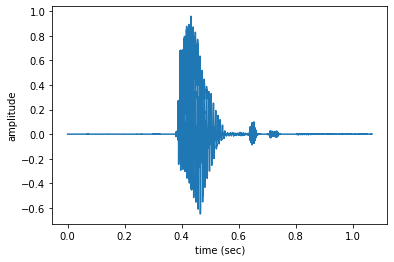

In [41]:
# Read an audio sample for input

sample_audio_input = 'single_digit_8_mono.wav'
x, fs = librosa.load(sample_audio_input)
t = np.arange(len(x))/fs  # t = array of evenly spaced values.
plt.plot(t,x)
plt.xlabel('time (sec)')
plt.ylabel('amplitude')
plt.show()
display(ipd.Audio(sample_audio_input))

### Extract features of the sample audio input (number 8)

In [42]:
#extract features for the sample audio
scale_audio = True

if scale_audio:
  x = x/np.max(np.abs(x))     #get maximum absolute value from the audio time series ndarray.

f0, voiced_flag = getPitch(x,fs,winLen=0.02)

power = np.sum(x**2)/len(x)
pitch_mean = np.nanmean(f0) if np.mean(np.isnan(f0))<1 else 0
pitch_std  = np.nanstd(f0) if np.mean(np.isnan(f0))<1 else 0
voiced_fr = np.mean(voiced_flag)

sample_input_features = [power,pitch_mean,pitch_std,voiced_fr]
sample_input_features = np.array(sample_input_features)
print(sample_input_features)

[8.79684350e-03 1.26430873e+02 3.93328812e+00 2.15053763e-01]


### Ask the trained model to predict the number of our sample audio input

In [43]:
sample_input_features = sample_input_features.reshape(1,-1)
#print(sample_input_features)

prediction_number = rfc_model.predict(sample_input_features)

print('Prediction of the classifier is :')
print(prediction_number)


Prediction of the classifier is :
[18]


## Conclusion

For a given sample audio input of number 8, the classifier model does not perform well and predicts the number to be 18 instead. There is lot of improvement needed which could be achieved by tuning the model hyperparameters.